# Market Basket Prediction 

## Predicting which products will Instacart customers buy again 

### Overview
Instacart is a grocery ordering and delivery app. Users select products from a local grocery store through the Instacart app, then personal shoppers do the in-store shopping and deliver to the users. Instacart has released an anonymized dataset for a kaggle competition which contains a sample of over 3 million grocery orders from more than 200,000 Instacart users. For each user, between 4 and 100 of their orders, with the sequence of products purchased in each order is provided. The data set is Accessed from https://www.instacart.com/datasets/grocery-shopping-2017  

The data dictionary is available here https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b

The objective of this project is to **predict which previously purchased products will be in a user’s next order.** This will be used in the app's 'Buy iy Again' feature. The business objective is to save customers time and thereby increasing the value of the service and customer retention by suggesting relevant products as users shop using the app. 

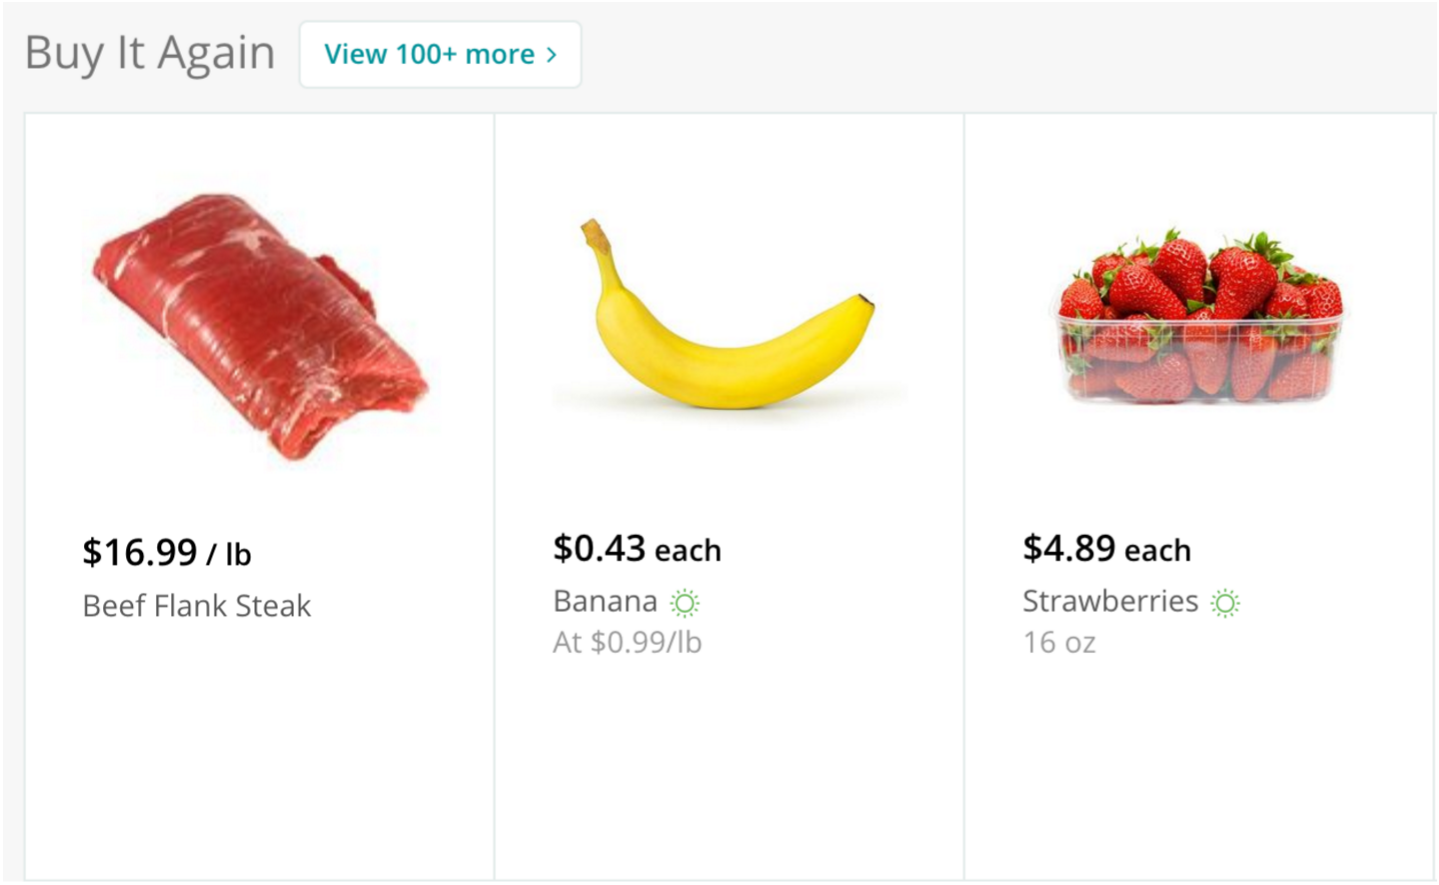

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid")

import os, glob

# selection, processing
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import preprocessing 

# models
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB 
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC

# metrics
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

import time
from collections import Counter

pd.set_option('display.max_columns', 500)
import warnings
warnings.filterwarnings('ignore') # Ignore all warnings

### About the Data

The data is distributed across six different CSV files. To understand the data better let us read all the files as data frame objects and preview their content.

In [118]:
# read the files and set dtypes for efficint memory
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
priors = pd.read_csv('order_products__prior.csv',dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})
train = pd.read_csv('order_products__train.csv', dtype={
            'order_id': np.int32,
            'product_id': np.uint16,
            'add_to_cart_order': np.int16,
            'reordered': np.int8})
orders = pd.read_csv('orders.csv', dtype={
        'order_id': np.int32,
        'user_id': np.int32,
        'eval_set': 'category',
        'order_number': np.int16,
        'order_dow': np.int8,
        'order_hour_of_day': np.int8,
        'days_since_prior_order': np.float32})
products = pd.read_csv('products.csv', dtype={
        'product_id': np.uint16,
        'order_id': np.int32,
        'aisle_id': np.uint8,
        'department_id': np.uint8},
        usecols=['product_id', 'product_name', 'aisle_id', 'department_id'])
#sample_submission = pd.read_csv('sample_submission.csv')

### Aisles

In [4]:
# Shape and preview aisles file
print('Aisles shape:', aisles.shape)
aisles.head()

Aisles shape: (134, 2)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


### Departments

In [5]:
print('Departments shape:', departments.shape)
departments.head()

Departments shape: (21, 2)


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


### Prior orders

In [6]:
print('orders prior shape', priors.shape)
priors.head()

orders prior shape (32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


### Train Orders

In [7]:
# Examine orders_train table
print('Order train shape:', train.shape)
train.head()

Order train shape: (1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


### Orders

In [9]:

print('Orders shape:', orders.shape)
orders.head()

('Orders shape:', (3421083, 7))


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


### Products

In [88]:
print('Products shape:', products.shape)
products.head()

Products shape: (49688, 4)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


The orders file has all the information about a given order by order_id such as user who has made the order, and when was it purchased. The variables in order_train and order_prior are same. We've mentioned above that the dataset contains 4 to 100 orders of a customer and our goal is to predict the products that a user will reordered. To make this possible, the last order of the user has been taken out and divided into train and test sets. All the prior order informations of the customer are present in order_prior file. We can also note that there is a variable in orders.csv file called eval_set which tells us whether a given order row is  a prior, train or test order.

The data files are all linked together with common identifiers and the following graph shows their relations and how they can be combined together. (from https://www.kaggle.com/c/instacart-market-basket-analysis/discussion/33128)

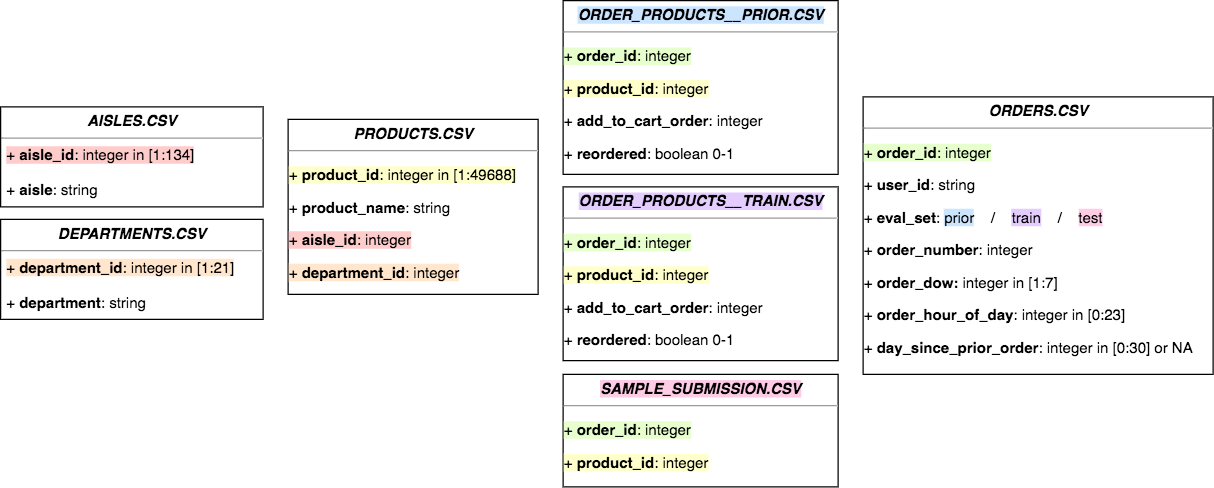

We'll extract different features for modeling. Before that let's explore the raw data


### Data Exploration
#### Order amount for each set
Of the more than 3.4 million orders, the majority is from previous orders. 

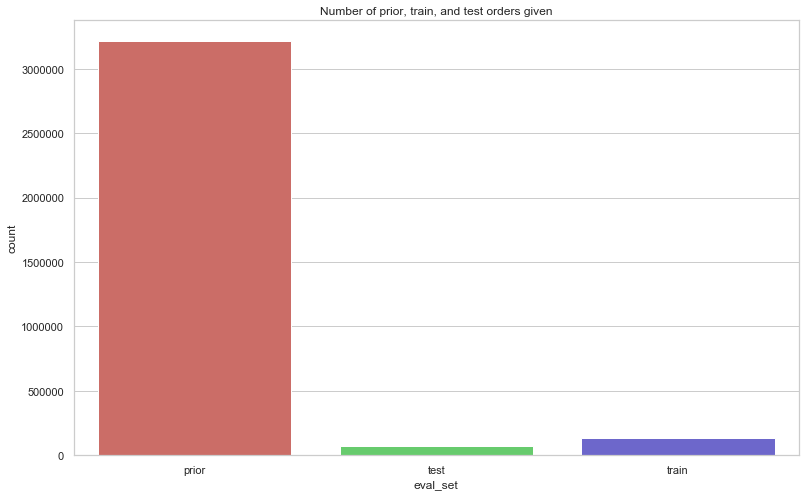

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64


In [77]:
# Compare each set count 
plt.figure(figsize=(13,8))
sns.countplot(x='eval_set', data=orders, palette='hls')
plt.title('Number of prior, train, and test orders given')
plt.show()

print(orders['eval_set'].value_counts())

In [78]:
# Total number of orders
print(orders['eval_set'].value_counts().sum())

3421083


In [79]:
print('Number of unique users', users.shape[0])

Number of unique users 206209


The orders above correspond to a total of 206,209 users of which 75000 are test users and 131209 are train users. Since there is only one user per order for train and test sets, we can simply take the length of train and test orders to get the number users corresponding to them.  

#### Orders per day of week
There is no significant difference between order amounts in different days of the week except for the week day 0 and 1. The data dictionary didn't give information on what days correspond to the numbers given. 


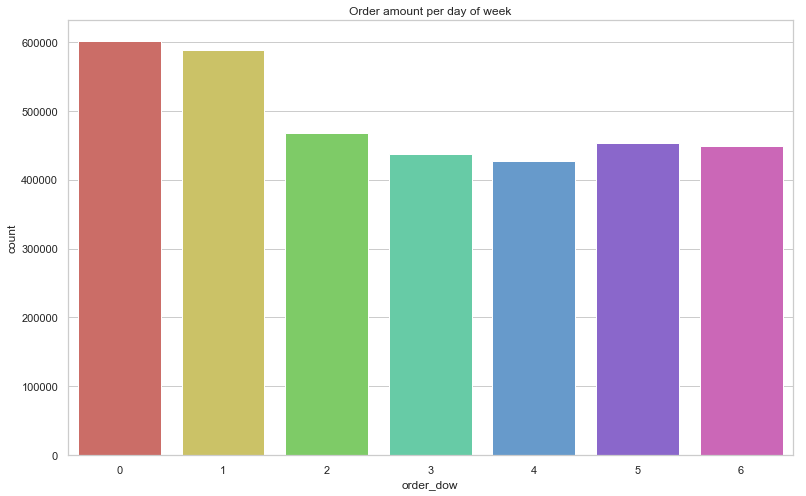

0    600905
1    587478
2    467260
5    453368
6    448761
3    436972
4    426339
Name: order_dow, dtype: int64


In [80]:
# Compare orders per day of the week 
plt.figure(figsize=(13,8))
sns.countplot(x='order_dow', data=orders, palette='hls')
plt.title('Order amount per day of week')
plt.show()
# print the values
print(orders['order_dow'].value_counts())

#### Orders per Hour of Day

As would be expected, most of the orders are made during the usual active hours of 9:00AM and 5:00PM

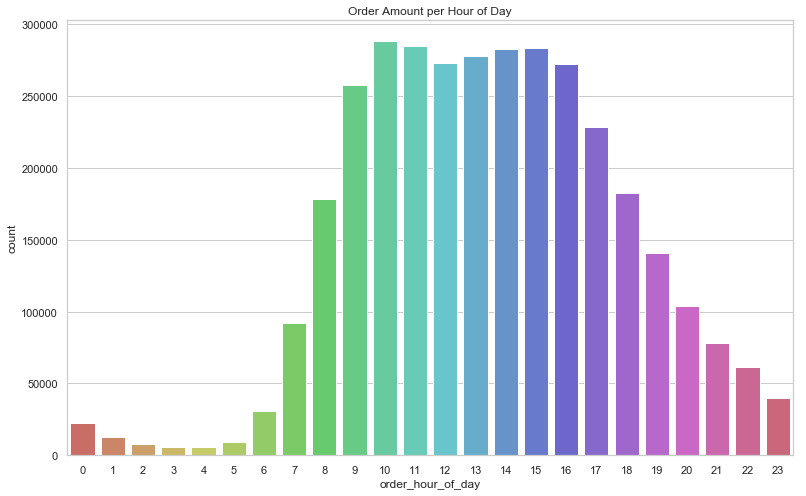

10    288418
11    284728
15    283639
14    283042
13    277999
12    272841
16    272553
9     257812
17    228795
18    182912
8     178201
19    140569
20    104292
7      91868
21     78109
22     61468
23     40043
6      30529
0      22758
1      12398
5       9569
2       7539
4       5527
3       5474
Name: order_hour_of_day, dtype: int64


In [81]:
# Compare orders per hour of day
plt.figure(figsize=(13,8))
sns.countplot(x='order_hour_of_day', data=orders, palette='hls')
plt.title('Order Amount per Hour of Day')
plt.show()
# print the values
print(orders['order_hour_of_day'].value_counts())

#### Days Since Last Order
We notice that there are spikes in number of orders every seventh day and at the turn of the month. Which indicates a pattern in users habits. 

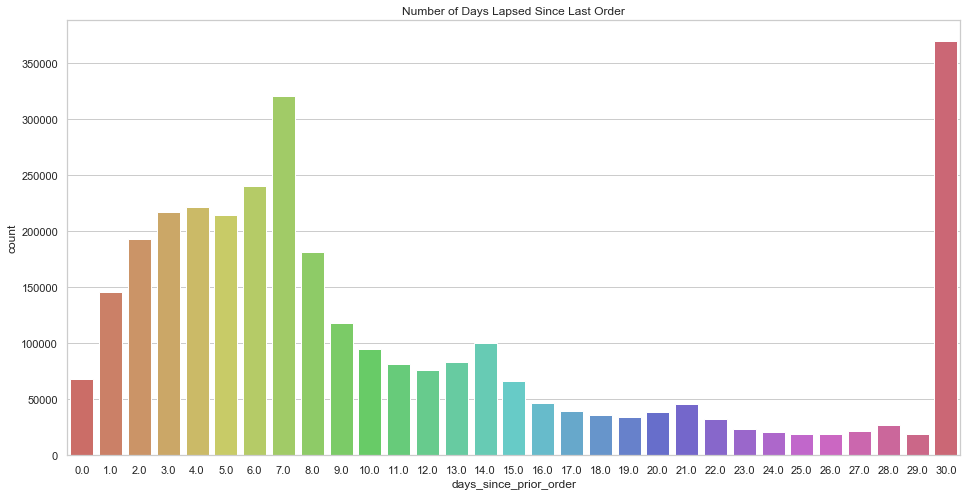

In [86]:
# Order intervals 
plt.figure(figsize=(16,8))
sns.countplot(x='days_since_prior_order', data=orders, palette='hls')
plt.title('Number of Days Lapsed Since Last Order')
plt.show()


#### Most Popular Producs
To see the most ordered products let's merge prior orders with the products table firse

In [100]:
# merge to get product name and order information in the same table 
order_products_prior = pd.merge(priors, products, on='product_id', how='left')

In [101]:
# inspect
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1,1,Organic Egg Whites,86,16
1,2,28985,2,1,Michigan Organic Kale,83,4
2,2,9327,3,0,Garlic Powder,104,13
3,2,45918,4,1,Coconut Butter,19,13
4,2,30035,5,0,Natural Sweetener,17,13


In [110]:
# Count the most common products  
cnt_srs = order_products_prior['product_name'].value_counts().reset_index().head(20)
cnt_srs.columns = ['product_name', 'count']
cnt_srs

,product_name,count
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
5,Organic Avocado,176815
6,Large Lemon,152657
7,Strawberries,142951
8,Limes,140627
9,Organic Whole Milk,137905


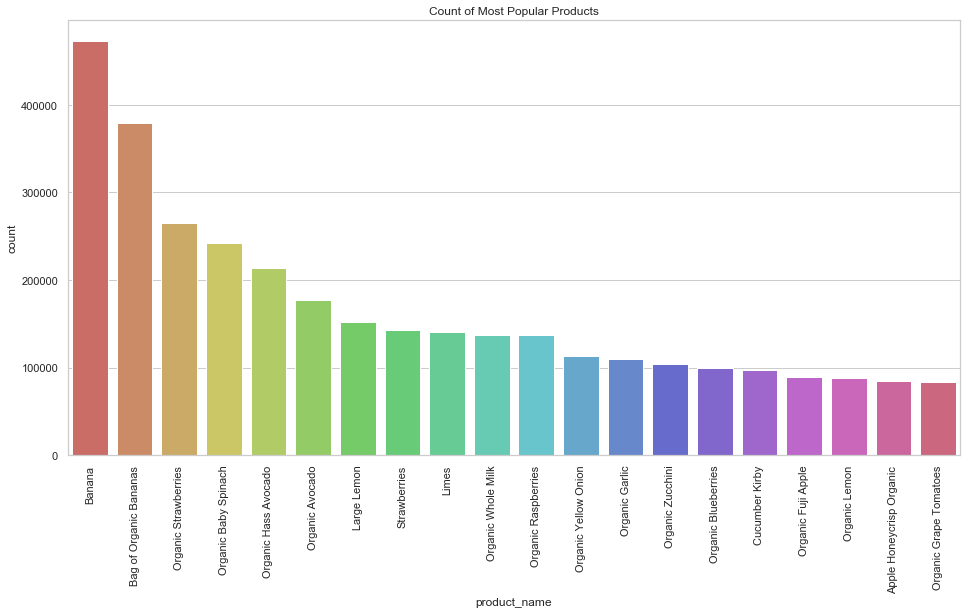

In [112]:
# Order intervals 
plt.figure(figsize=(16,8))
sns.barplot(x='product_name', y='count', data=cnt_srs, palette='hls')
plt.title('Count of Most Popular Products')
plt.xticks(rotation=90)
plt.show()

Interestingly the first most popular product is banana and the second most popular product is also banana. Most of the top 20 products we ploted above are organic products and except for organic whole milk, all others are either fruits or vegitables. here it is not clear whether that says a lot about eating habits of Instacart users or American consumers in general. 

We can do similar combinations to make more visualization and analysis for Aisles, and departments. We now have a better feel of the dataset. 

In [113]:
# Save memory
del order_products_prior, cnt_srs  

### Problem Approach and Feature Generation
Our approach to make future prediction is to make a list of all unique products that a user has ordered previously and predict the probabiity that each individual product will be reordered by the same user. The list will be a unique user product pair. We will then split the 'train' data in to training and evaluation sets. That way we will be able to evaluate the model before making prediction useing the test set. 

We'll create features at users, product, and order labels and the feature names will be self explanatory. 

In [120]:
#Reorder rate. reorder to order ratio
#product features
prods = pd.DataFrame()
prods['orders'] = priors.groupby(priors.product_id).size().astype(np.int32)
prods['reorders'] = priors['reordered'].groupby(priors.product_id).sum().astype(np.float32)
prods['reorder_rate'] = (prods.reorders / prods.orders).astype(np.float32)
products = products.join(prods, on='product_id')
products.set_index('product_id', drop=False, inplace=True)

In [121]:
products.head()

,product_id,aisle_id,department_id,orders,reorders,reorder_rate
product_id,,,,,,
1,1,61,19,1852.0,1136.0,0.613391
2,2,104,13,90.0,12.0,0.133333
3,3,94,7,277.0,203.0,0.732852
4,4,38,1,329.0,147.0,0.446809
5,5,5,13,15.0,9.0,0.600000


In [119]:
# Drop product name to help with memory issues later and use user_instead
products.drop('product_name', 1, inplace=True)

In [122]:
#add order and priors
orders.set_index('order_id', inplace=True, drop=False)
priors = priors.join(orders, on='order_id', rsuffix='_')
priors.drop('order_id_', inplace=True, axis=1)

In [123]:
# user features
usr = pd.DataFrame()
usr['average_days_between_orders'] = orders.groupby('user_id')['days_since_prior_order'].mean().astype(np.float32)
usr['nb_orders'] = orders.groupby('user_id').size().astype(np.int16)

users = pd.DataFrame()
users['total_items'] = priors.groupby('user_id').size().astype(np.int16)
users['all_products'] = priors.groupby('user_id')['product_id'].apply(set)
users['total_distinct_items'] = (users.all_products.map(len)).astype(np.int16)

users = users.join(usr)
# Average size of user basket 
users['average_basket'] = (users.total_items / users.nb_orders).astype(np.float32)
print('Number of unique users', users.shape[0])

Number of unique users 206209


In [124]:
# userXproduct features. User product pair 
priors['user_product'] = priors.product_id + priors.user_id * 100000

In [125]:
# preview 
priors.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,user_product
0,2,33120,1,1,202279,prior,3,5,9,8.0,-1246903360
1,2,28985,2,1,202279,prior,3,5,9,8.0,-1246907495
2,2,9327,3,0,202279,prior,3,5,9,8.0,-1246927153
3,2,45918,4,1,202279,prior,3,5,9,8.0,-1246890562
4,2,30035,5,0,202279,prior,3,5,9,8.0,-1246906445


In [126]:
# Aggregates every unique product that a unique user has previously bought
d= dict()
for row in priors.itertuples():
    z = row.user_product
    if z not in d:
        d[z] = (1,
                (row.order_number, row.order_id),
                row.add_to_cart_order)
    else:
        d[z] = (d[z][0] + 1,
                max(d[z][1], (row.order_number, row.order_id)),
                d[z][2] + row.add_to_cart_order)

In [127]:
# Convert dictionary to pandas data frame 

userXproduct = pd.DataFrame.from_dict(d, orient='index')
del d
userXproduct.columns = ['nb_orders', 'last_order_id', 'sum_pos_in_cart']
userXproduct.nb_orders = userXproduct.nb_orders.astype(np.int16)
userXproduct.last_order_id = userXproduct.last_order_id.map(lambda x: x[1]).astype(np.int32)
userXproduct.sum_pos_in_cart = userXproduct.sum_pos_in_cart.astype(np.int16)
print('number of user product pair ', len(userXproduct))


number of user product pair  13293564


Since the total user product pair is too huge to use, we'll use the ones with 'train' label for modeling. 

In [128]:
# Split train / test orders

test_orders = orders[orders.eval_set == 'test']
train_orders = orders[orders.eval_set == 'train']

train.set_index(['order_id', 'product_id'], inplace=True, drop=False)

In [132]:
train_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,,
1187899,1187899,1,train,11,4,8,14.0
1492625,1492625,2,train,15,1,11,30.0
2196797,2196797,5,train,5,0,11,6.0
525192,525192,7,train,21,2,11,6.0
880375,880375,8,train,4,1,14,10.0


In [181]:
test_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
order_id,,,,,,,
2774568,2774568,3,test,13,5,15,11.0
329954,329954,4,test,6,3,12,30.0
1528013,1528013,6,test,4,3,16,22.0
1376945,1376945,11,test,8,6,11,8.0
1356845,1356845,12,test,6,1,20,30.0


In [129]:
# build list of candidate products to reorder, with features

def features(selected_orders, labels_given=False):
    print('build candidate list')
    order_list = []
    product_list = []
    labels = []
    i=0
    for row in selected_orders.itertuples():
        i+=1
        if i%1000000 == 0: print('order row',i)
        order_id = row.order_id
        user_id = row.user_id
        user_products = users.all_products[user_id]
        product_list += user_products
        order_list += [order_id] * len(user_products)
        if labels_given:
            labels += [(order_id, product) in train.index for product in user_products]
            '''Returns a true/false list whether or not a certain product is in a certain order 
            based on previously built list of all unique products a user has ever bought.
            '''
        
    df = pd.DataFrame({'order_id':order_list, 'product_id':product_list}, dtype=np.int32)
    labels = np.array(labels, dtype=np.int8)
    del order_list
    del product_list
    
    # User level features
    df['user_id'] = df.order_id.map(orders.user_id)
    df['user_total_orders'] = df.user_id.map(users.nb_orders)
    df['user_total_items'] = df.user_id.map(users.total_items)
    df['total_distinct_items'] = df.user_id.map(users.total_distinct_items)
    df['user_average_days_between_orders'] = df.user_id.map(users.average_days_between_orders)
    df['user_average_basket'] =  df.user_id.map(users.average_basket)
    
    # Order level features
    df['order_hour_of_day'] = df.order_id.map(orders.order_hour_of_day)
    df['days_since_prior_order'] = df.order_id.map(orders.days_since_prior_order)
    df['days_since_ratio'] = df.days_since_prior_order / df.user_average_days_between_orders
    
    # Product level features
    df['aisle_id'] = df.product_id.map(products.aisle_id)
    df['department_id'] = df.product_id.map(products.department_id)
    df['product_orders'] = df.product_id.map(products.orders).astype(np.int32)
    df['product_reorders'] = df.product_id.map(products.reorders)
    df['product_reorder_rate'] = df.product_id.map(products.reorder_rate)

    # user-product pair features
    df['z'] = df.user_id * 100000 + df.product_id
    df.drop(['user_id'], axis=1, inplace=True)
    df['UP_orders'] = df.z.map(userXproduct.nb_orders)
    df['UP_orders_ratio'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_last_order_id'] = df.z.map(userXproduct.last_order_id)
    df['UP_average_pos_in_cart'] = (df.z.map(userXproduct.sum_pos_in_cart) / df.UP_orders).astype(np.float32)
    df['UP_reorder_rate'] = (df.UP_orders / df.user_total_orders).astype(np.float32)
    df['UP_orders_since_last'] = df.user_total_orders - df.UP_last_order_id.map(orders.order_number)
    df['UP_delta_hour_vs_last'] = abs(df.order_hour_of_day - df.UP_last_order_id.map(orders.order_hour_of_day)).map(lambda x: min(x, 24-x)).astype(np.int8)
    
    df.drop(['UP_last_order_id', 'z'], axis=1, inplace=True)
    
    return (df, labels)

In [131]:
# Create the list 
df_train, labels = features(train_orders, labels_given=True)



build candidate list


In [134]:
df_train.shape

(8474661, 21)

In [191]:
labels[:10]

array([0, 1, 1, 1, 0, 1, 1, 1, 0, 1], dtype=int8)

We will use the following features for modeling. This makes it easier to select fewer features if needed.  

In [13]:
# features to use 
f_to_use = ['user_total_orders', 'user_total_items', 'total_distinct_items',
       'user_average_days_between_orders', 'user_average_basket',
       'order_hour_of_day', 'days_since_prior_order', 'days_since_ratio',
       'aisle_id', 'department_id', 'product_orders', 'product_reorders',
       'product_reorder_rate', 'UP_orders', 'UP_orders_ratio',
       'UP_average_pos_in_cart', 'UP_reorder_rate', 'UP_orders_since_last',
       'UP_delta_hour_vs_last'] 

In [136]:
# add the label. this will be target variable
df_train['reordered'] = labels

In [193]:
# preview
df_train.head()

,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,days_since_ratio,aisle_id,department_id,product_orders,product_reorders,product_reorder_rate,UP_orders,UP_orders_ratio,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_hour_vs_last,reordered
0,1187899,17122,11,59,18,19.0,5.363636,8,14.0,0.736842,24,4,13880,9377.0,0.675576,1,0.090909,6.0,0.090909,6,7,0
1,1187899,196,11,59,18,19.0,5.363636,8,14.0,0.736842,77,7,35791,27791.0,0.776480,10,0.909091,1.4,0.909091,1,0,1
2,1187899,26405,11,59,18,19.0,5.363636,8,14.0,0.736842,54,17,1214,536.0,0.441516,2,0.181818,5.0,0.181818,7,1,1
3,1187899,46149,11,59,18,19.0,5.363636,8,14.0,0.736842,77,7,8558,6953.0,0.812456,3,0.272727,3.0,0.272727,1,0,1
4,1187899,14084,11,59,18,19.0,5.363636,8,14.0,0.736842,91,16,15935,12923.0,0.810982,1,0.090909,2.0,0.090909,10,0,0


The labeled train data can now be split in to training and evaluation set. That way we will be able to evaluate the performance of our models. 

In [15]:
# define target variable and other features
X = df_train.drop('reordered', 1)
Y = df_train['reordered']

In [194]:
# split the train data for evaluation 

X_train, X_eval, y_train, y_eval = train_test_split(
    X, Y, test_size=0.2, random_state=2)

## Prediction
### Gradient Boosting with Light GBM Model
LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is fast and suited for large datasets and as a result we will try it as our first model. Light GBM grows tree vertically while other algorithm grows trees horizontally meaning that Light GBM grows tree leaf-wise while other algorithm grows level-wise. It will choose the leaf with max delta loss to grow.

Documentation
https://lightgbm.readthedocs.io/en/latest/


In [195]:
#preparing for Light GBM
lgb_train = lgb.Dataset(X_train[f_to_use], label=y_train)
lgb_eval = lgb.Dataset(X_eval[f_to_use], y_eval, reference = lgb_train)

In [196]:
params = {}
params['task'] = 'train'
params['learning_rate'] = 0.05
params['boosting_type'] = 'gbdt'
params['objective'] = 'binary'
params['metric'] = {'auc', 'binary_logloss'}
params['sub_feature'] = 0.5
params['num_leaves'] = 600
params['min_data'] = 200
params['max_bin'] = 100
params['num_iterations'] = 1000
params['feature_fraction'] = 0.8
params['bagging_fraction'] = 0.95
params['num_boost_round'] = 400
params['bagging_freq'] = 5


In [197]:
# Train a light GBM model 
lgb_model = lgb.train(params, lgb_train, valid_sets = lgb_eval, early_stopping_rounds=15)



[1]	valid_0's binary_logloss: 0.31045	valid_0's auc: 0.825167
Training until validation scores don't improve for 15 rounds.
[2]	valid_0's binary_logloss: 0.303328	valid_0's auc: 0.825848
[3]	valid_0's binary_logloss: 0.297437	valid_0's auc: 0.826278
[4]	valid_0's binary_logloss: 0.292393	valid_0's auc: 0.826851
[5]	valid_0's binary_logloss: 0.288883	valid_0's auc: 0.826755
[6]	valid_0's binary_logloss: 0.284965	valid_0's auc: 0.827221
[7]	valid_0's binary_logloss: 0.281524	valid_0's auc: 0.827581
[8]	valid_0's binary_logloss: 0.278456	valid_0's auc: 0.82783
[9]	valid_0's binary_logloss: 0.27571	valid_0's auc: 0.828068
[10]	valid_0's binary_logloss: 0.273233	valid_0's auc: 0.828239
[11]	valid_0's binary_logloss: 0.271432	valid_0's auc: 0.828168
[12]	valid_0's binary_logloss: 0.269805	valid_0's auc: 0.827905
[13]	valid_0's binary_logloss: 0.267886	valid_0's auc: 0.828185
[14]	valid_0's binary_logloss: 0.266558	valid_0's auc: 0.827847
[15]	valid_0's binary_logloss: 0.26494	valid_0's auc: 

[129]	valid_0's binary_logloss: 0.244228	valid_0's auc: 0.834848
[130]	valid_0's binary_logloss: 0.244217	valid_0's auc: 0.834868
[131]	valid_0's binary_logloss: 0.244193	valid_0's auc: 0.834905
[132]	valid_0's binary_logloss: 0.244177	valid_0's auc: 0.834935
[133]	valid_0's binary_logloss: 0.244162	valid_0's auc: 0.834958
[134]	valid_0's binary_logloss: 0.244151	valid_0's auc: 0.83498
[135]	valid_0's binary_logloss: 0.244135	valid_0's auc: 0.835006
[136]	valid_0's binary_logloss: 0.244109	valid_0's auc: 0.835049
[137]	valid_0's binary_logloss: 0.244091	valid_0's auc: 0.835081
[138]	valid_0's binary_logloss: 0.244061	valid_0's auc: 0.835133
[139]	valid_0's binary_logloss: 0.244042	valid_0's auc: 0.835168
[140]	valid_0's binary_logloss: 0.244027	valid_0's auc: 0.8352
[141]	valid_0's binary_logloss: 0.244016	valid_0's auc: 0.835227
[142]	valid_0's binary_logloss: 0.244002	valid_0's auc: 0.835258
[143]	valid_0's binary_logloss: 0.243998	valid_0's auc: 0.835265
[144]	valid_0's binary_loglo

[256]	valid_0's binary_logloss: 0.243269	valid_0's auc: 0.836557
[257]	valid_0's binary_logloss: 0.243268	valid_0's auc: 0.836559
[258]	valid_0's binary_logloss: 0.243267	valid_0's auc: 0.83656
[259]	valid_0's binary_logloss: 0.243264	valid_0's auc: 0.836569
[260]	valid_0's binary_logloss: 0.24326	valid_0's auc: 0.836574
[261]	valid_0's binary_logloss: 0.243256	valid_0's auc: 0.836583
[262]	valid_0's binary_logloss: 0.243252	valid_0's auc: 0.836593
[263]	valid_0's binary_logloss: 0.243245	valid_0's auc: 0.836602
[264]	valid_0's binary_logloss: 0.243236	valid_0's auc: 0.83662
[265]	valid_0's binary_logloss: 0.24323	valid_0's auc: 0.836633
[266]	valid_0's binary_logloss: 0.243224	valid_0's auc: 0.836642
[267]	valid_0's binary_logloss: 0.24322	valid_0's auc: 0.836646
[268]	valid_0's binary_logloss: 0.24322	valid_0's auc: 0.836645
[269]	valid_0's binary_logloss: 0.243217	valid_0's auc: 0.836649
[270]	valid_0's binary_logloss: 0.243194	valid_0's auc: 0.836684
[271]	valid_0's binary_logloss:

[383]	valid_0's binary_logloss: 0.242869	valid_0's auc: 0.83724
[384]	valid_0's binary_logloss: 0.24287	valid_0's auc: 0.837238
[385]	valid_0's binary_logloss: 0.242868	valid_0's auc: 0.837242
[386]	valid_0's binary_logloss: 0.242862	valid_0's auc: 0.837255
[387]	valid_0's binary_logloss: 0.242853	valid_0's auc: 0.83727
[388]	valid_0's binary_logloss: 0.242852	valid_0's auc: 0.837271
[389]	valid_0's binary_logloss: 0.242848	valid_0's auc: 0.837279
[390]	valid_0's binary_logloss: 0.242847	valid_0's auc: 0.837281
[391]	valid_0's binary_logloss: 0.242841	valid_0's auc: 0.83729
[392]	valid_0's binary_logloss: 0.242841	valid_0's auc: 0.83729
[393]	valid_0's binary_logloss: 0.242841	valid_0's auc: 0.837289
[394]	valid_0's binary_logloss: 0.242837	valid_0's auc: 0.8373
[395]	valid_0's binary_logloss: 0.242837	valid_0's auc: 0.8373
[396]	valid_0's binary_logloss: 0.242834	valid_0's auc: 0.837306
[397]	valid_0's binary_logloss: 0.242831	valid_0's auc: 0.83731
[398]	valid_0's binary_logloss: 0.2

[510]	valid_0's binary_logloss: 0.242541	valid_0's auc: 0.837803
[511]	valid_0's binary_logloss: 0.242538	valid_0's auc: 0.837807
[512]	valid_0's binary_logloss: 0.242537	valid_0's auc: 0.83781
[513]	valid_0's binary_logloss: 0.242533	valid_0's auc: 0.837817
[514]	valid_0's binary_logloss: 0.242533	valid_0's auc: 0.837818
[515]	valid_0's binary_logloss: 0.242531	valid_0's auc: 0.837822
[516]	valid_0's binary_logloss: 0.242524	valid_0's auc: 0.837834
[517]	valid_0's binary_logloss: 0.242519	valid_0's auc: 0.837842
[518]	valid_0's binary_logloss: 0.242519	valid_0's auc: 0.837843
[519]	valid_0's binary_logloss: 0.242519	valid_0's auc: 0.837841
[520]	valid_0's binary_logloss: 0.242518	valid_0's auc: 0.837845
[521]	valid_0's binary_logloss: 0.242515	valid_0's auc: 0.83785
[522]	valid_0's binary_logloss: 0.242516	valid_0's auc: 0.83785
[523]	valid_0's binary_logloss: 0.242514	valid_0's auc: 0.837852
[524]	valid_0's binary_logloss: 0.242513	valid_0's auc: 0.837854
[525]	valid_0's binary_loglo

[637]	valid_0's binary_logloss: 0.242328	valid_0's auc: 0.838184
[638]	valid_0's binary_logloss: 0.242323	valid_0's auc: 0.838193
[639]	valid_0's binary_logloss: 0.242324	valid_0's auc: 0.838191
[640]	valid_0's binary_logloss: 0.242324	valid_0's auc: 0.838191
[641]	valid_0's binary_logloss: 0.242325	valid_0's auc: 0.838189
[642]	valid_0's binary_logloss: 0.242324	valid_0's auc: 0.838189
[643]	valid_0's binary_logloss: 0.242325	valid_0's auc: 0.838187
[644]	valid_0's binary_logloss: 0.242326	valid_0's auc: 0.838187
[645]	valid_0's binary_logloss: 0.242326	valid_0's auc: 0.838187
[646]	valid_0's binary_logloss: 0.242322	valid_0's auc: 0.838195
[647]	valid_0's binary_logloss: 0.242319	valid_0's auc: 0.838201
[648]	valid_0's binary_logloss: 0.242314	valid_0's auc: 0.83821
[649]	valid_0's binary_logloss: 0.242313	valid_0's auc: 0.838212
[650]	valid_0's binary_logloss: 0.242312	valid_0's auc: 0.838213
[651]	valid_0's binary_logloss: 0.242314	valid_0's auc: 0.838208
[652]	valid_0's binary_log

The model has trained with 650 itterations using binary_logloss auc loss functions. 

#### Evaluation
let's make a prediction for the test set so that and evaluate the result. The prediction returns probability scores between 0 and 1. We'll use a threshold value to change it to binary. 

In [200]:
# Predict for evaluation set 
X_eval['pred'] = lgb_model.predict(X_eval[f_to_use], num_iterations = lgb_model.best_iteration)

In [202]:
X_eval['pred'].head()

8319756    0.092174
1169791    0.018365
3163396    0.036531
3373214    0.000989
8389207    0.269756
Name: pred, dtype: float64

In [203]:
# Change to binary for evaluation 
X_eval['pred'] = np.where(X_eval['pred'] >= 0.5, 1, X_eval['pred'].astype(int))

In [204]:
# Evaluating validation set 
#Confusion matrix for validation set 
print('Confusion matrix')
print(confusion_matrix(y_eval, X_eval['pred']))

# Classification report 
print(classification_report(y_eval, X_eval['pred']))


Confusion matrix
[[1512876   16713]
 [ 134530   30814]]
              precision    recall  f1-score   support

           0       0.92      0.99      0.95   1529589
           1       0.65      0.19      0.29    165344

   micro avg       0.91      0.91      0.91   1694933
   macro avg       0.78      0.59      0.62   1694933
weighted avg       0.89      0.91      0.89   1694933



In [51]:
#Accuracy
from sklearn.metrics import accuracy_score
accuracy=accuracy_score(X_eval['reordered'],y_eval)
print('Accuracy:', accuracy)

('Accuracy:', 0.87748955268438344)


The confusion matrix and classification report do not seem promising although the accuracy score seems high. We will use this model as a benchmark and try to improve the score by first balancing the classes and also by using other models. 

## Adjust Class Imbalance 



The number of user product pairs not reordered outnumbers the reordered ones. Balancing the classes is likely to give us a better result. in addition it will also help us reduce the data to a size that most models can handle.  

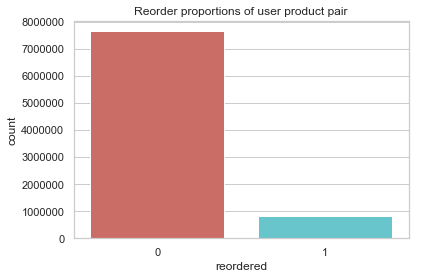

0    7645837
1     828824
Name: reordered, dtype: int64


In [137]:
sns.countplot(x='reordered', data=df_train, palette='hls')
plt.title('Reorder proportions of user product pair')
plt.show()
print(df_train['reordered'].value_counts())

1    828824
0    828824
Name: reordered, dtype: int64
Balanced train class


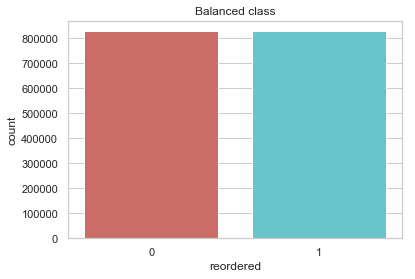

In [16]:
#Import module and resampling 

from sklearn.utils import resample

# Separate majority and minority classes
data_majority = df_train[df_train.reordered==0]
data_minority = df_train[df_train.reordered==1]
 
# Downsample majority overall class

data_majority_downsampled = resample(data_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=828824,     # new sample size
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority overall class
df_train_resampled = pd.concat([data_minority, data_majority_downsampled])
 
# Display new class counts
print(df_train_resampled.reordered.value_counts())
print('Balanced train class')

sns.countplot(x='reordered', data=df_train_resampled, palette='hls')
plt.title('Balanced class')
plt.show()

In [140]:
df_train_resampled.isnull().sum()

order_id                            0
product_id                          0
user_total_orders                   0
user_total_items                    0
total_distinct_items                0
user_average_days_between_orders    0
user_average_basket                 0
order_hour_of_day                   0
days_since_prior_order              0
days_since_ratio                    0
aisle_id                            0
department_id                       0
product_orders                      0
product_reorders                    0
product_reorder_rate                0
UP_orders                           0
UP_orders_ratio                     0
UP_average_pos_in_cart              0
UP_reorder_rate                     0
UP_orders_since_last                0
UP_delta_hour_vs_last               0
reordered                           0
dtype: int64

In [17]:
# Replace missing values with the mean
df_train_resampled = df_train_resampled.fillna(df_train_resampled.mean())

In [138]:
# Define target variable 
X = df_train_resampled.drop('reordered', 1)
Y = df_train_resampled['reordered']

In [143]:
X_train_re.shape

(1326118, 21)

In [142]:
# split the resampled train data for evaluation 
X_train_re, X_eval_re, y_train_re, y_eval_re = train_test_split(
    X, Y, test_size=0.2, random_state=2)

#### Light GBM with resampled data

In [49]:
#preparing resampled data for Light GBM
lgb_train_re = lgb.Dataset(X_train_re, label=y_train_re)
lgb_eval_re = lgb.Dataset(X_eval_re, y_eval_re, reference = lgb_train_re)

In [50]:
# define and train the model with the resampled data and similar parameters
lgb_model_re = lgb.train(params, lgb_train_re, valid_sets = lgb_eval_re, early_stopping_rounds=15)

[1]	valid_0's auc: 0.825272	valid_0's binary_logloss: 0.677495
Training until validation scores don't improve for 15 rounds.
[2]	valid_0's auc: 0.826225	valid_0's binary_logloss: 0.663491
[3]	valid_0's auc: 0.826602	valid_0's binary_logloss: 0.65072
[4]	valid_0's auc: 0.827047	valid_0's binary_logloss: 0.639028
[5]	valid_0's auc: 0.826826	valid_0's binary_logloss: 0.630522
[6]	valid_0's auc: 0.82724	valid_0's binary_logloss: 0.620611
[7]	valid_0's auc: 0.82751	valid_0's binary_logloss: 0.611564
[8]	valid_0's auc: 0.827652	valid_0's binary_logloss: 0.603292
[9]	valid_0's auc: 0.827867	valid_0's binary_logloss: 0.595696
[10]	valid_0's auc: 0.828	valid_0's binary_logloss: 0.588738
[11]	valid_0's auc: 0.827864	valid_0's binary_logloss: 0.583609
[12]	valid_0's auc: 0.827547	valid_0's binary_logloss: 0.578905
[13]	valid_0's auc: 0.827843	valid_0's binary_logloss: 0.573275
[14]	valid_0's auc: 0.827444	valid_0's binary_logloss: 0.569339
[15]	valid_0's auc: 0.82782	valid_0's binary_logloss: 0.5

[129]	valid_0's auc: 0.833928	valid_0's binary_logloss: 0.502318
[130]	valid_0's auc: 0.833943	valid_0's binary_logloss: 0.502294
[131]	valid_0's auc: 0.833955	valid_0's binary_logloss: 0.50227
[132]	valid_0's auc: 0.833992	valid_0's binary_logloss: 0.502217
[133]	valid_0's auc: 0.834001	valid_0's binary_logloss: 0.502199
[134]	valid_0's auc: 0.834031	valid_0's binary_logloss: 0.502156
[135]	valid_0's auc: 0.834063	valid_0's binary_logloss: 0.50211
[136]	valid_0's auc: 0.834085	valid_0's binary_logloss: 0.502081
[137]	valid_0's auc: 0.834097	valid_0's binary_logloss: 0.502062
[138]	valid_0's auc: 0.834116	valid_0's binary_logloss: 0.502032
[139]	valid_0's auc: 0.834127	valid_0's binary_logloss: 0.502017
[140]	valid_0's auc: 0.83414	valid_0's binary_logloss: 0.501999
[141]	valid_0's auc: 0.834143	valid_0's binary_logloss: 0.501996
[142]	valid_0's auc: 0.834153	valid_0's binary_logloss: 0.501982
[143]	valid_0's auc: 0.834158	valid_0's binary_logloss: 0.501977
[144]	valid_0's auc: 0.83417

[257]	valid_0's auc: 0.835063	valid_0's binary_logloss: 0.500783
[258]	valid_0's auc: 0.835066	valid_0's binary_logloss: 0.500781
[259]	valid_0's auc: 0.83507	valid_0's binary_logloss: 0.500777
[260]	valid_0's auc: 0.835067	valid_0's binary_logloss: 0.500783
[261]	valid_0's auc: 0.835068	valid_0's binary_logloss: 0.500782
[262]	valid_0's auc: 0.835077	valid_0's binary_logloss: 0.500771
[263]	valid_0's auc: 0.835088	valid_0's binary_logloss: 0.500757
[264]	valid_0's auc: 0.835107	valid_0's binary_logloss: 0.500731
[265]	valid_0's auc: 0.835113	valid_0's binary_logloss: 0.500723
[266]	valid_0's auc: 0.835114	valid_0's binary_logloss: 0.500721
[267]	valid_0's auc: 0.835114	valid_0's binary_logloss: 0.50072
[268]	valid_0's auc: 0.835113	valid_0's binary_logloss: 0.500722
[269]	valid_0's auc: 0.835126	valid_0's binary_logloss: 0.500705
[270]	valid_0's auc: 0.835134	valid_0's binary_logloss: 0.500695
[271]	valid_0's auc: 0.835141	valid_0's binary_logloss: 0.500685
[272]	valid_0's auc: 0.8351

[385]	valid_0's auc: 0.835475	valid_0's binary_logloss: 0.500291
[386]	valid_0's auc: 0.835479	valid_0's binary_logloss: 0.500283
[387]	valid_0's auc: 0.835478	valid_0's binary_logloss: 0.500285
[388]	valid_0's auc: 0.835476	valid_0's binary_logloss: 0.500288
[389]	valid_0's auc: 0.835482	valid_0's binary_logloss: 0.50028
[390]	valid_0's auc: 0.835479	valid_0's binary_logloss: 0.500282
[391]	valid_0's auc: 0.835481	valid_0's binary_logloss: 0.50028
[392]	valid_0's auc: 0.835484	valid_0's binary_logloss: 0.500277
[393]	valid_0's auc: 0.835478	valid_0's binary_logloss: 0.500285
[394]	valid_0's auc: 0.835481	valid_0's binary_logloss: 0.500282
[395]	valid_0's auc: 0.835476	valid_0's binary_logloss: 0.500287
[396]	valid_0's auc: 0.835483	valid_0's binary_logloss: 0.500281
[397]	valid_0's auc: 0.835485	valid_0's binary_logloss: 0.500279
[398]	valid_0's auc: 0.835479	valid_0's binary_logloss: 0.500287
[399]	valid_0's auc: 0.835481	valid_0's binary_logloss: 0.500285
[400]	valid_0's auc: 0.8354

The model takes fewr iteration to train that the previous. 

In [51]:
# Predict for evaluation set 
X_eval_re['reordered'] = lgb_model_re.predict(X_eval_re, num_iterations = lgb_model_re.best_iteration)

In [52]:
# Change to binary for evaluation using lower threshold 
X_eval_re['reordered']=np.where(X_eval_re['reordered'] > 0.22, 1, X_eval_re['reordered'].astype(int))

In [56]:
#Confusion matrix for resampled validation set 
print('Confusion matrix')
print(confusion_matrix(y_eval_re, X_eval_re['reordered']))

# Classification report 
print(classification_report(y_eval_re, X_eval_re['reordered']))

Confusion matrix
[[ 69277  96530]
 [  9485 156238]]
             precision    recall  f1-score   support

          0       0.88      0.42      0.57    165807
          1       0.62      0.94      0.75    165723

avg / total       0.75      0.68      0.66    331530



In [59]:
#Accuracy for resampled model
from sklearn.metrics import accuracy_score
accuracy_re=accuracy_score(X_eval_re['reordered'],y_eval_re)
print('Accuracy:', accuracy_re)

('Accuracy:', 0.68022501734383012)


The classification report and confusion matrix result has improved but not good enough to get a useful prediction. 

## Random Forest

In [ ]:
Dont run the cell below!  

In [ ]:
# Too slow. kernel interupted after 30hrs 
# Random forest with GridsearchCV
start_time = time.clock()
forest_para = {'criterion':['gini','entropy'],'n_estimators':[10,20,50,70,100,250,400],'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50]}
forest = GridSearchCV(ensemble.RandomForestClassifier(), forest_para, cv=5)
grid_fit_forest = forest.fit(X_train_re, y_train_re)

best_forest = grid_fit_forest.best_estimator_
y_forest = best_forest.predict(X_eval_re)

#Print best parameters
print('forest_para:', forest.best_params_)

# Evaluations
score_forest = cross_val_score(best_forest, df_train_re.drop('reordered', 1), df_train_re['reordered'], cv=5)
print(score_forest)

#Confusion matrix for random forest
print('Confusion matrix')
print(confusion_matrix(y_eval_re, y_forest))

# Classification report 
print(classification_report(y_eval_re, y_forest))

# AUC for random forest classifier
y_forest_proba = forest.predict_proba(X_eval_re)[::,1]
fpr_forest, tpr_forest, _ = metrics.roc_curve(y_eval_re,  y_forest)
auc_forest = metrics.roc_auc_score(y_eval_re, y_forest_proba)
plt.plot(fpr_forest,tpr_forest,label='auc_forest='+str(auc_forest))
plt.legend(loc=4)
plt.show()
print('\nRuntime: {} seconds'.format(round((time.clock()-start_time),2)))


### KNN Classifier

[ 0.65342712  0.65396402  0.64978946  0.64834164  0.65228276  0.64998432
  0.65437007  0.65003861  0.65321783  0.65266282]
('Training set score:', 1.0)
('\nTest set score:', 0.65045697221970866)
             precision    recall  f1-score   support

          0       0.66      0.62      0.64    165807
          1       0.64      0.68      0.66    165723

avg / total       0.65      0.65      0.65    331530

Confusion matrix
[[102978  62829]
 [ 53055 112668]]


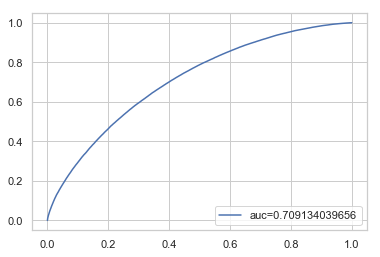


Runtime: 609.44 seconds


In [81]:
# Fit the data to knn model 
start_time = time.clock()
neigh = KNeighborsClassifier(n_neighbors=25, weights='distance')
neigh.fit(X_train_re, y_train_re)
y_knn = neigh.predict(X_eval_re)

# score
score_neigh = cross_val_score(neigh, X, Y, cv=10)
print(score_neigh)
print('Training set score:', neigh.score(X_train_re, y_train_re))
print('\nTest set score:', neigh.score(X_eval_re, y_eval_re))

# Classification report 
print(classification_report(y_eval_re, y_knn))

#Confusion matrix 
print('Confusion matrix')
print(confusion_matrix(y_eval_re, y_knn))

# AUC 
y_pred_proba = neigh.predict_proba(X_eval_re)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_eval_re,  y_pred_proba)
auc = metrics.roc_auc_score(y_eval_re, y_pred_proba)
plt.plot(fpr,tpr,label='auc='+str(auc))
plt.legend(loc=4)
plt.show()
print('\nRuntime: {} seconds'.format(round((time.clock()-start_time),2)))

KNN classifier has a better precision and recall scores. The training set score is 100% which is a sign of overfitting. Let's now use Logistic Regression model with L1 regularization parameter which is likely to address overfitting.  

### Logistic Regression with L1 regularization parameter and GridSearchCV

In [57]:
# Logistics regression with GridSearchCV
start_time = time.clock()
grid_para = C = {'C': [0.001, 0.01, 0.1, 1, 10]}#Inverse of regularization strength; smaller values specify stronger regularization.
logreg = GridSearchCV(LogisticRegression(penalty='l1'), grid_para, cv=5)
grid_fit_logreg = logreg.fit(X_train_re, y_train_re)
best_logreg = grid_fit_logreg.best_estimator_


# Predict using the test set
y_logreg = best_logreg.predict(X_eval_re)

Training set score: 0.7418555513159463

Test set score: 0.7400989352396465
Confusion matrix
[[121955  43852]
 [ 42313 123410]]
              precision    recall  f1-score   support

           0       0.74      0.74      0.74    165807
           1       0.74      0.74      0.74    165723

   micro avg       0.74      0.74      0.74    331530
   macro avg       0.74      0.74      0.74    331530
weighted avg       0.74      0.74      0.74    331530



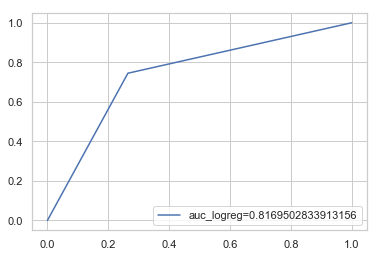


Runtime: 1493.62 seconds


In [58]:
# Compare scores for train and test sets
print('Training set score:', best_logreg.score(X_train_re, y_train_re))
print('\nTest set score:', best_logreg.score(X_eval_re, y_eval_re))

# Ten fold cross validation score to evaluate the model *** Took too long 
#score_logreg = cross_val_score(logreg, X, Y, cv=5)
#print(score_logreg)

#Confusion matrix for logistics regression classifier
print('Confusion matrix')
print(confusion_matrix(y_eval_re, y_logreg))

# Classification report 
print(classification_report(y_eval_re, y_logreg))

# AUC classifier
y_logreg_proba = logreg.predict_proba(X_eval_re)[::,1]
fpr_logreg, tpr_logreg, _ = metrics.roc_curve(y_eval_re,  y_logreg)
auc_logreg = metrics.roc_auc_score(y_eval_re, y_logreg_proba)
plt.plot(fpr_logreg,tpr_logreg,label='auc_logreg='+str(auc_logreg))
plt.legend(loc=4)
plt.show()
print('\nRuntime: {} seconds'.format(round((time.clock()-start_time),2)))

The difference between the training and evaluation sets is very small suggesting that the regularization parameter has helped with overfitting. The overall score has also improved. 

## Dimentionality reduction 
### Principal Component Analysis (PCA)
Now let's apply PCA to our data and see if we can improve the models we tried above. 

In [34]:
# original shape of the data set 
X.shape

(1657648, 19)

In [19]:
# transform  
X_tra = StandardScaler().fit_transform(X)

In [20]:
# Initiate pca (92% of the varience )
pca =PCA(n_components=11)

In [21]:
# Fit with selected features
X_pca = pca.fit_transform(X_tra)

# Varience in pca
varience = pca.explained_variance_ratio_.cumsum()
print('Varience expained by principal components:', varience)

Varience expained by principal components: [0.20630604 0.3481364  0.44021306 0.52315676 0.5922888  0.64140317
 0.68942608 0.73706285 0.783641   0.82951539 0.87043788]


In [22]:
# Train test split for PCA components
X_train_pca, X_eval_pca, y_train_pca, y_eval_pca = train_test_split(X_pca, Y, test_size = 0.2, random_state = 2)

### KNN with PCA components 

[ 0.72075094  0.72283822  0.71914627  0.71882654  0.72179725  0.72039164
  0.72135084  0.717689    0.72029512  0.72023479]
('Training set score:', 1.0)
('\nTest set score:', 0.72496305010104667)
             precision    recall  f1-score   support

          0       0.72      0.73      0.73    165807
          1       0.73      0.72      0.72    165723

avg / total       0.72      0.72      0.72    331530

Confusion matrix
[[120677  45130]
 [ 46053 119670]]


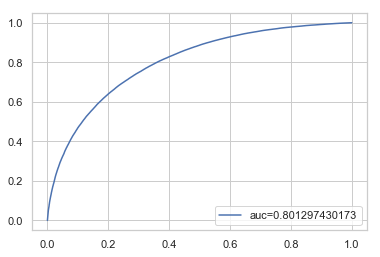


Runtime: 7503.38 seconds


In [60]:
# Fit the data to knn model 
start_time = time.clock()
neigh_pca = KNeighborsClassifier(n_neighbors=25, weights='distance')
neigh_pca.fit(X_train_pca, y_train_pca)
y_knn_pca = neigh_pca.predict(X_eval_pca)

# score
score_neigh_pca = cross_val_score(neigh_pca, X_pca, Y, cv=10)
print(score_neigh_pca)
print('Training set score:', neigh_pca.score(X_train_pca, y_train_pca))
print('\nTest set score:', neigh_pca.score(X_eval_pca, y_eval_pca))

# Classification report 
print(classification_report(y_eval_pca, y_knn_pca))

#Confusion matrix 
print('Confusion matrix')
print(confusion_matrix(y_eval_pca, y_knn_pca))

# AUC 
y_pred_proba = neigh_pca.predict_proba(X_eval_pca)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_eval_pca,  y_pred_proba)
auc = metrics.roc_auc_score(y_eval_pca, y_pred_proba)
plt.plot(fpr,tpr,label='auc='+str(auc))
plt.legend(loc=4)
plt.show()
print('\nRuntime: {} seconds'.format(round((time.clock()-start_time),2)))

PCA has improved the KNN classifier but the issue with overfitting is still present. 

### Logistics Regression with L1 regularization parameter (and PCA)

In [61]:
# Logistic regression with GridSearchCV
start_time = time.clock()
grid_para = C = {'C': [0.001, 0.01, 0.1, 1, 10]}
logreg = GridSearchCV(LogisticRegression(penalty='l1'), grid_para, cv=5)
grid_fit_logreg = logreg.fit(X_train_pca, y_train_pca)
best_logreg_pca = grid_fit_logreg.best_estimator_


# Predict using the test set
y_logreg = best_logreg_pca.predict(X_eval_pca)

('Training set score:', 0.73039578680026962)
('\nTest set score:', 0.72984043676288723)
Confusion matrix
[[124976  40831]
 [ 48735 116988]]
             precision    recall  f1-score   support

          0       0.72      0.75      0.74    165807
          1       0.74      0.71      0.72    165723

avg / total       0.73      0.73      0.73    331530



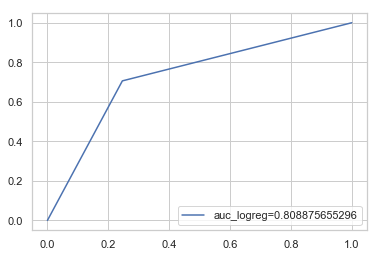


Runtime: 46.36 seconds


In [62]:
# Compare scores for train and test sets
print('Training set score:', logreg.score(X_train_pca, y_train_pca))
print('\nTest set score:', logreg.score(X_eval_pca, y_eval_pca))

# Ten fold cross validation score to evaluate the model *** Took too long 
#score_logreg = cross_val_score(logreg, X_pca, Y, cv=5)
#print(score_logreg)

#Confusion matrix for logistics regression classifier
print('Confusion matrix')
print(confusion_matrix(y_eval_pca, y_logreg))

# Classification report 
print(classification_report(y_eval_pca, y_logreg))

# AUC classifier
y_logreg_proba = best_logreg_pca.predict_proba(X_eval_pca)[::,1]
fpr_logreg, tpr_logreg, _ = metrics.roc_curve(y_eval_pca,  y_logreg)
auc_logreg = metrics.roc_auc_score(y_eval_pca, y_logreg_proba)
plt.plot(fpr_logreg,tpr_logreg,label='auc_logreg='+str(auc_logreg))
plt.legend(loc=4)
plt.show()
print('\nRuntime: {} seconds'.format(round((time.clock()-start_time),2)))

This model is not improved as a result of PCA  

### Light GBM with PCA components 

In [63]:
#preparing resampled data for Light GBM
lgb_train_pca = lgb.Dataset(X_train_pca, label=y_train_pca)
lgb_eval_pca = lgb.Dataset(X_eval_pca, y_eval_pca, reference = lgb_train_pca)

In [64]:
# define and train the model with PCA components.
lgb_model_pca = lgb.train(params, lgb_train_pca, valid_sets = lgb_eval_pca, early_stopping_rounds=15)

[1]	valid_0's auc: 0.787826	valid_0's binary_logloss: 0.68077
Training until validation scores don't improve for 15 rounds.
[2]	valid_0's auc: 0.793238	valid_0's binary_logloss: 0.671904
[3]	valid_0's auc: 0.804215	valid_0's binary_logloss: 0.660054
[4]	valid_0's auc: 0.807024	valid_0's binary_logloss: 0.6493
[5]	valid_0's auc: 0.808646	valid_0's binary_logloss: 0.639969
[6]	valid_0's auc: 0.809409	valid_0's binary_logloss: 0.630953
[7]	valid_0's auc: 0.809111	valid_0's binary_logloss: 0.624569
[8]	valid_0's auc: 0.809646	valid_0's binary_logloss: 0.617368
[9]	valid_0's auc: 0.809196	valid_0's binary_logloss: 0.61212
[10]	valid_0's auc: 0.809824	valid_0's binary_logloss: 0.605431
[11]	valid_0's auc: 0.810272	valid_0's binary_logloss: 0.599292
[12]	valid_0's auc: 0.810618	valid_0's binary_logloss: 0.59365
[13]	valid_0's auc: 0.810741	valid_0's binary_logloss: 0.588792
[14]	valid_0's auc: 0.810679	valid_0's binary_logloss: 0.585395
[15]	valid_0's auc: 0.810884	valid_0's binary_logloss: 0

[130]	valid_0's auc: 0.816438	valid_0's binary_logloss: 0.523559
[131]	valid_0's auc: 0.816443	valid_0's binary_logloss: 0.523552
[132]	valid_0's auc: 0.816451	valid_0's binary_logloss: 0.523538
[133]	valid_0's auc: 0.816466	valid_0's binary_logloss: 0.52352
[134]	valid_0's auc: 0.81648	valid_0's binary_logloss: 0.5235
[135]	valid_0's auc: 0.8165	valid_0's binary_logloss: 0.523477
[136]	valid_0's auc: 0.816511	valid_0's binary_logloss: 0.523461
[137]	valid_0's auc: 0.816515	valid_0's binary_logloss: 0.523454
[138]	valid_0's auc: 0.816527	valid_0's binary_logloss: 0.523437
[139]	valid_0's auc: 0.816553	valid_0's binary_logloss: 0.523403
[140]	valid_0's auc: 0.816563	valid_0's binary_logloss: 0.523389
[141]	valid_0's auc: 0.816584	valid_0's binary_logloss: 0.523366
[142]	valid_0's auc: 0.816594	valid_0's binary_logloss: 0.523355
[143]	valid_0's auc: 0.816615	valid_0's binary_logloss: 0.52333
[144]	valid_0's auc: 0.816618	valid_0's binary_logloss: 0.523325
[145]	valid_0's auc: 0.816632	va

In [76]:
# Convert X_eval_pca to dataframe 
X_eval_pca = pd.DataFrame(X_eval_pca)

In [77]:
# Predict for evaluation set 
X_eval_pca['reordered'] = lgb_model_pca.predict(X_eval_pca, num_iterations = lgb_model_pca.best_iteration)

In [74]:
df22 = pd.DataFrame(X_eval_pca)

In [79]:
X_eval_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,reordered
0,-0.275181,-1.852440,-0.140705,0.488728,-0.566406,1.664559,0.712279,1.109652,0.175572,0.093192,1.584934,0.178203
1,-3.522444,-0.847865,-0.140998,-0.207417,-0.803712,0.116090,-0.713167,-0.186744,-0.479721,1.516163,0.615559,0.039083
2,-0.132344,1.744714,1.356244,1.194705,1.993706,-0.281744,-1.305478,-0.717233,1.251316,-0.836309,0.347810,0.864667
3,3.564326,0.109336,0.123660,-0.269001,0.397243,-0.288725,-1.644279,0.742242,0.455863,1.161751,0.306671,0.768371
4,1.222661,-0.549666,-0.822013,-0.955754,1.869648,0.211733,-0.508959,-1.235421,0.568475,-0.757177,-0.144759,0.530461


In [80]:
# Change to binary for evaluation 
X_eval_pca['reordered']=np.where(X_eval_pca['reordered'] > 0.22, 1, X_eval_pca['reordered'].astype(int))

In [82]:
#Confusion matrix for resampled validation set 
print('Confusion matrix')
print(confusion_matrix(y_eval_pca, X_eval_pca['reordered']))

# Classification report 
print(classification_report(y_eval_pca, X_eval_pca['reordered']))

Confusion matrix
[[ 62051 103756]
 [  8820 156903]]
             precision    recall  f1-score   support

          0       0.88      0.37      0.52    165807
          1       0.60      0.95      0.74    165723

avg / total       0.74      0.66      0.63    331530



In [85]:
#Accuracy for resampled model
from sklearn.metrics import accuracy_score
accuracy_pca=accuracy_score(X_eval_pca['reordered'],y_eval_pca)
print('Accuracy:', accuracy_pca)

('Accuracy:', 0.66043495309625067)


The results have improved but overall Light GBM is not performing as well logistics regression and KNN classifier. 

## Dimentionality Reduction with Select K Best

In [247]:
# original shape 
X.shape

(1657648, 19)

In [254]:
# Select only two third of the features based on f_classif.
from sklearn.feature_selection import f_classif
selection = SelectKBest(score_func=f_classif, k=13)
X_kbest = selection.fit(X, Y).transform(X)

In [259]:
# Split training and testing data 
X_train_k, X_eval_k, y_train_k, y_eval_k = train_test_split(X_kbest, Y, test_size = 0.2, random_state = 2)

### Logistic Regression With GridSearchCV and Kbest features 

Training set score: 0.7409551789508928

Test set score: 0.7397942870931741
Confusion matrix
[[122019  43788]
 [ 42478 123245]]
              precision    recall  f1-score   support

           0       0.74      0.74      0.74    165807
           1       0.74      0.74      0.74    165723

   micro avg       0.74      0.74      0.74    331530
   macro avg       0.74      0.74      0.74    331530
weighted avg       0.74      0.74      0.74    331530



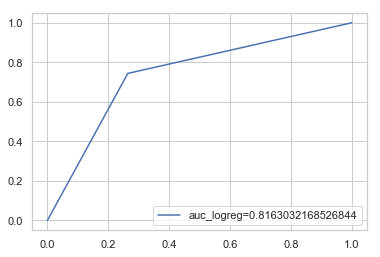


Runtime: 964.43 seconds


In [260]:
# Logistic regression with GridSearchCV
start_time = time.clock()
grid_para = C = {'C': [0.001, 0.01, 0.1, 1, 10]}
logreg_k = GridSearchCV(LogisticRegression(penalty='l1'), grid_para, cv=5)
grid_fit_logreg_k = logreg_k.fit(X_train_k, y_train_k)
best_logreg_k = grid_fit_logreg_k.best_estimator_


# Predict using the test set
y_logreg_k = best_logreg_k.predict(X_eval_k)

# Compare scores for train and test sets
print('Training set score:', best_logreg_k.score(X_train_k, y_train_k))
print('\nTest set score:', best_logreg_k.score(X_eval_k, y_eval_k))

# Ten fold cross validation score to evaluate the model *** Took too long 
#score_logreg = cross_val_score(best_logreg_k, X_kbest, Y, cv=5)
#print(score_logreg)

#Confusion matrix for logistics regression classifier
print('Confusion matrix')
print(confusion_matrix(y_eval_k, y_logreg_k))

# Classification report 
print(classification_report(y_eval_k, y_logreg_k))

# AUC classifier
y_logreg_proba = best_logreg_k.predict_proba(X_eval_k)[::,1]
fpr_logreg, tpr_logreg, _ = metrics.roc_curve(y_eval_k,  y_logreg_k)
auc_logreg = metrics.roc_auc_score(y_eval_k, y_logreg_proba)
plt.plot(fpr_logreg,tpr_logreg,label='auc_logreg='+str(auc_logreg))
plt.legend(loc=4)
plt.show()
print('\nRuntime: {} seconds'.format(round((time.clock()-start_time),2)))

A slight improvement in the score using selectkbest 

### Predicting with Kmeans Clusters. 

We will train a kmeans clustering algorithm and see if it can accurately predict our target variable. The data was too huge for other clustering methods so we will only use kmeans which is relatively easy to train using lower computational power.  

**Use original features to make it possible for analysis of the cluster solutions** 

In [23]:
X_train, X_eval, y_train, y_eval = train_test_split(X, Y, test_size = 0.2, random_state = 2)

### K Means

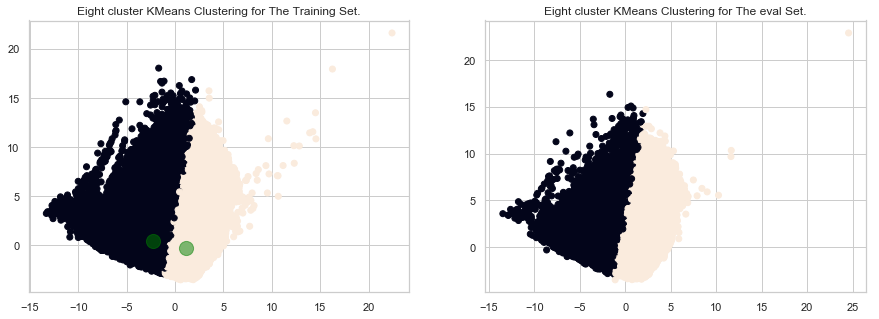

Train set ARI 0.044796719096824596
Eval set ARI 0.0429305003392912


In [34]:
# initialize the algorithm
from sklearn.cluster import KMeans

km = KMeans(n_clusters = 2, random_state=2) 

# Calculate predicted values
y_pred_km = km.fit_predict(X_train_pca)
# predict eval set clusters 
y_pred_km_eval = km.predict(X_eval_pca)

# Plot the solution using the first 2 pca components 
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_pred_km)
centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='green', s=200, alpha=0.5)# Green dots show cluster centers. 
plt.title('Eight cluster KMeans Clustering for The Training Set.')

plt.subplot(122)
plt.scatter(X_eval_pca[:, 0], X_eval_pca[:, 1], c=y_pred_km_eval)
plt.title('Eight cluster KMeans Clustering for The eval Set.')
plt.show()

# adjusted rand index
print('Train set ARI', metrics.adjusted_rand_score(y_train_pca, y_pred_km))
print('Eval set ARI', metrics.adjusted_rand_score(y_eval_pca, y_pred_km_eval))

The Adjusted Rand index score shows that this clustering is close random. A perfect cluster has a value of 1 and a random assignment has a value of 0.5. This is not a good cluster and we'll make a couple of graphical comparisions to see the difference with the ground truth. 

In [35]:
# Column for assigned cluster in the train and eval sets 
X_train['cluster'] = y_pred_km
X_eval['cluster'] = y_pred_km_eval

In [57]:
# add the ground truth for comparision
X_train['reorder'] = y_train

In [58]:
# inspect changes
X_train.head()

,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,days_since_ratio,aisle_id,department_id,product_orders,product_reorders,product_reorder_rate,UP_orders,UP_orders_ratio,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_hour_vs_last,cluster,reorder
6757694,2457391,329,7,91,47,14.833333,13.000000,22,9.0,0.606742,84,16,15459,12345.0,0.798564,4,0.571429,5.500000,0.571429,1,10,1,0
17994,2769206,11463,55,658,157,6.407407,11.963636,14,7.0,1.092486,96,20,1504,875.0,0.581782,23,0.418182,4.739130,0.418182,1,2,0,1
1140889,2343881,24808,10,109,82,15.333333,10.900000,12,30.0,1.956522,5,13,197,60.0,0.304569,1,0.100000,10.000000,0.100000,2,4,1,0
1479612,601501,19660,16,66,31,14.266666,4.125000,20,6.0,0.420561,115,7,56087,45558.0,0.812274,7,0.437500,2.285714,0.437500,1,2,1,1
8420835,1994934,41842,84,534,139,4.373494,6.357143,13,3.0,0.685950,52,1,3314,2264.0,0.683162,20,0.238095,2.950000,0.238095,1,7,0,1


The count plot below shows that the cluster solution is very different from the ground truth. 

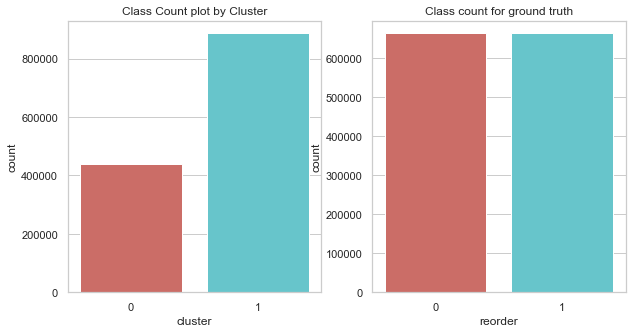

In [64]:
# Count plot of each classes for cluster solution and ground truth 
plt.figure(figsize=(10,5))
plt.subplot(121)
sns.countplot(x='cluster', data=X_train, palette='hls')
plt.title('Class Count plot by Cluster')

plt.subplot(122)
sns.countplot(x='reorder', data=X_train, palette='hls')
plt.title('Class count for ground truth')

plt.show()

The following is an example of differenced between ground truth and clustering solution. 

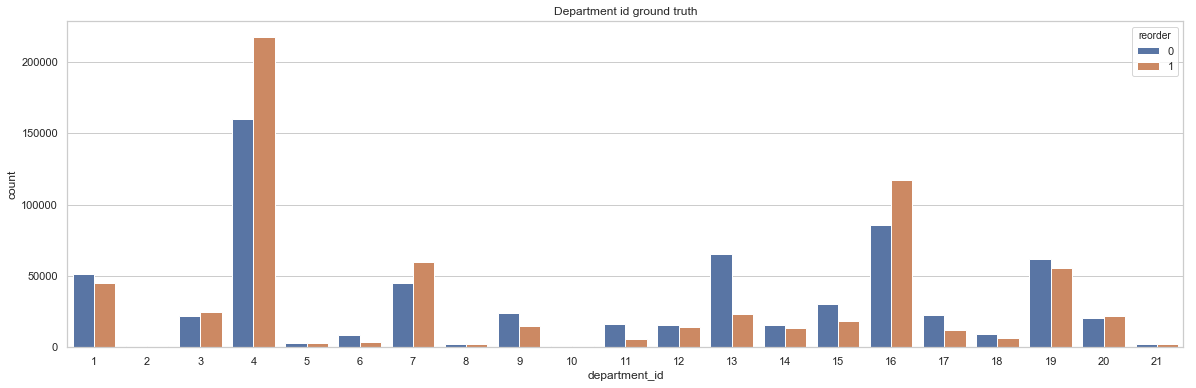

In [59]:
# Department id in ground truth 
plt.figure(figsize=(20, 6))
sns.countplot('department_id', data=X_train, hue = 'reorder')
plt.title('Department id ground truth')

plt.show()

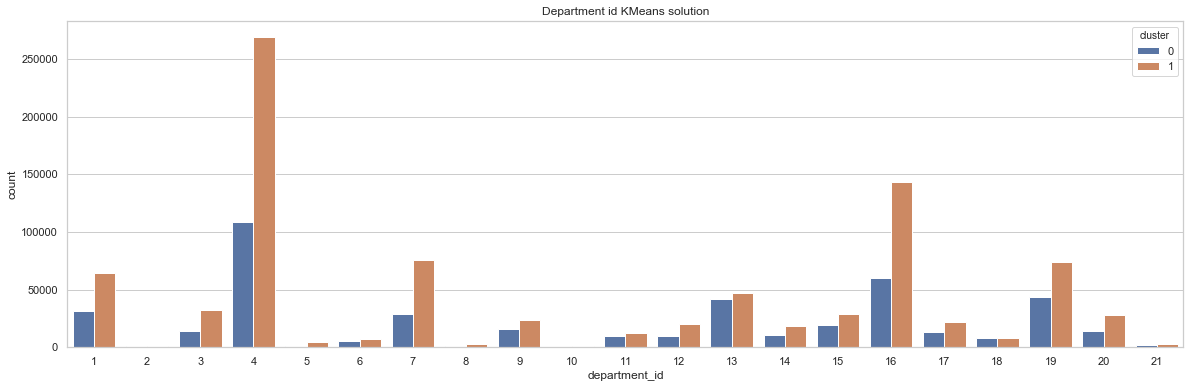

In [60]:
# Department id in cluster solution 
plt.figure(figsize=(20, 6))
sns.countplot('department_id', data=X_train, hue = 'cluster')
plt.title('Department id KMeans solution')

plt.show()

### Generate more clusters as a feature for supervised learning

Now we will try to use kmeans clustering to create additional feature to the data set which then can be used to try and improve the supervised model algorithms above. We will only apply this approach on the best performing model so far. We will use the elbow method to select optimal K value by plotting the sum of square errors verses different K values. In our graph, the optimal K value is 5. 

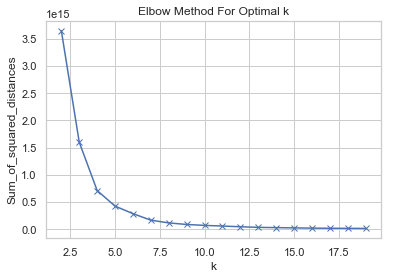

In [262]:
# Elbow graph to select optimal K 
from sklearn.cluster import KMeans
X_km = X
Sum_of_squared_distances = []
K = range(2,20)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

We now create a cluster based using five clusters 

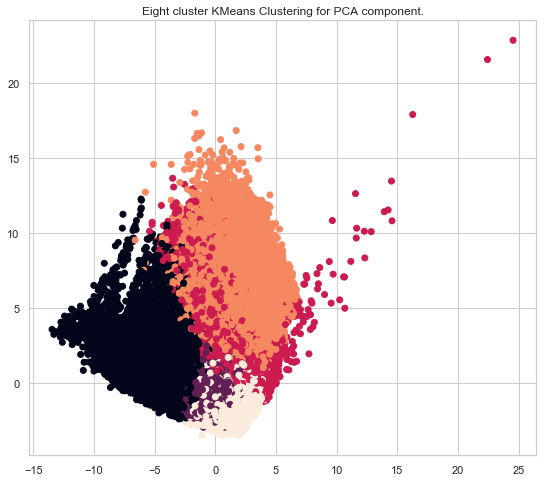

0.0377897047794093

Runtime: 153.71 seconds


In [68]:
# Create a cluster to be added to PCA component before train test split
start_time = time.clock()
# initialize the algorithm
km_pca = KMeans(n_clusters = 5, random_state=42) 

# Calculate predicted values
y_pred_km_pca = km_pca.fit_predict(X_pca)

# Plot the solution using the first 2 lsa components 
plt.figure(figsize=(20,8))

plt.subplot(121)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_km_pca)
plt.title('Eight cluster KMeans Clustering for PCA component.')

plt.show()
print(metrics.adjusted_rand_score(Y, y_pred_km_pca))
print('\nRuntime: {} seconds'.format(round((time.clock()-start_time),2)))

In [69]:
# Create a dataframe for the cluster and join with X_pca as a feature
cluster = pd.DataFrame(y_pred_km_pca)
cluster.columns = ['cluster']

In [70]:
# Convert to dataframe for merging 
X_pca_df = pd.DataFrame(X_pca)

In [71]:
# Add the outcome back onto X_pca
X_pca_clu = X_pca_df.join(cluster, how='inner')

In [72]:
# inspect changes
X_pca_clu.head()

,0,1,2,3,4,5,6,7,8,9,10,cluster
0,4.093754,2.419948,1.612214,2.449643,0.220566,-1.754786,1.217187,-0.456984,-0.986526,-0.006799,0.796598,2
1,1.073342,-1.631694,-0.361266,1.218247,-0.338245,-1.676418,0.249808,-0.489787,0.614002,0.560038,-0.617189,1
2,2.044402,-0.207644,-0.559771,1.166873,-0.340406,-1.541312,-1.845329,-0.647202,0.049696,0.168737,-0.006742,1
3,1.707332,-0.879830,0.210653,1.395580,-0.330824,-1.719433,-0.000648,-0.494427,-1.548726,-0.125547,-0.656029,1
4,1.126661,-1.404114,-0.565142,1.172606,-0.295956,-1.769758,0.600601,-0.474020,1.114872,0.686688,-0.964346,1


We have a new feature and now we will train the logistic regression model which gave us a better result previously and see if we can improve the model.  

In [73]:
# Train test split 
X_train_clu, X_eval_clu, y_train_clu, y_eval_clu = train_test_split(X_pca_clu, Y, test_size = 0.2, random_state = 2)

### Logistic Regression with KMeans Cluster Feature

In [74]:
# Logistic regression with GridSearchCV
start_time = time.clock()
grid_para = C = {'C': [0.001, 0.01, 0.1, 1, 10]}
logreg = GridSearchCV(LogisticRegression(penalty='l1'), grid_para, cv=5)
grid_fit_logreg = logreg.fit(X_train_clu, y_train_clu)
best_logreg_clu = grid_fit_logreg.best_estimator_


# Predict using the test set
y_logreg = best_logreg_clu.predict(X_eval_clu)

Training set score: 0.7189413008495473

Test set score: 0.71697282297228
Confusion matrix
[[129427  36380]
 [ 57452 108271]]
              precision    recall  f1-score   support

           0       0.69      0.78      0.73    165807
           1       0.75      0.65      0.70    165723

   micro avg       0.72      0.72      0.72    331530
   macro avg       0.72      0.72      0.72    331530
weighted avg       0.72      0.72      0.72    331530



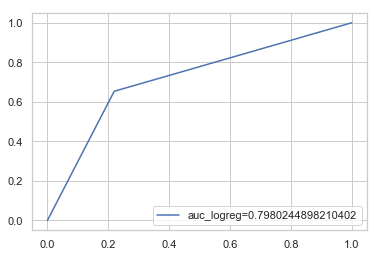


Runtime: 108.99 seconds


In [75]:
# Compare scores for train and test sets
print('Training set score:', best_logreg_clu.score(X_train_clu, y_train_clu))
print('\nTest set score:', best_logreg_clu.score(X_eval_clu, y_eval_clu))

# Ten fold cross validation score to evaluate the model *** Took too long 
#score_logreg = cross_val_score(logreg, X_pca_clu, Y, cv=5)
#print(score_logreg)

#Confusion matrix for logistics regression classifier
print('Confusion matrix')
print(confusion_matrix(y_eval_clu, y_logreg))

# Classification report 
print(classification_report(y_eval_clu, y_logreg))

# AUC classifier
y_logreg_proba = best_logreg_clu.predict_proba(X_eval_clu)[::,1]
fpr_logreg, tpr_logreg, _ = metrics.roc_curve(y_eval_clu,  y_logreg)
auc_logreg = metrics.roc_auc_score(y_eval_clu, y_logreg_proba)
plt.plot(fpr_logreg,tpr_logreg,label='auc_logreg='+str(auc_logreg))
plt.legend(loc=4)
plt.show()
print('\nRuntime: {} seconds'.format(round((time.clock()-start_time),2)))

As the adjusted rand index indicated, the cluster is close to random and as shown in the model above, it does not improve the results. 

The reson why kmeans is not performing well here could be that kmeans assumes that the true clusters are uniform in all directions (isotropic) and that all clusters have similar variances.

## Neural Network Models
Finally we will use Neural Network models for prediction. We will apply Multi Layer Perceptron Model(MLP) and Convolutional Neural Net (CNN)

### Multi Layer Perceptrons (MLP)

In [150]:
# Import componenets
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, MaxPooling2D, MaxPooling1D, BatchNormalization, Activation, Conv1D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.neural_network import MLPClassifier


# Import the backend
from keras import backend as K

Using TensorFlow backend.


We will use the data without applying PCA for neural nets. 

In [146]:
# split the resampled train data for evaluation 
# work with resampled data with out pca 
X_train_nn, X_eval_nn, y_train_nn, y_eval_nn = train_test_split(
    X, Y, test_size=0.2, random_state=2)

In [151]:
start_time = time.clock()
# Now apply the transformations to the data:
X_train_nn = StandardScaler().fit_transform(X_train_nn)
X_eval_nn = StandardScaler().fit_transform(X_eval_nn)
mlp = MLPClassifier(hidden_layer_sizes=(40, 40, 20, 2), random_state=42, verbose=True, early_stopping=True)
mlp.fit(X_train_nn, y_train_nn)
print('\nRuntime: {} seconds'.format(round((time.clock()-start_time),2)))

Iteration 1, loss = 0.58662437
Validation score: 0.752059
Iteration 2, loss = 0.51262826
Validation score: 0.752624
Iteration 3, loss = 0.50998084
Validation score: 0.753378
Iteration 4, loss = 0.50855049
Validation score: 0.753823
Iteration 5, loss = 0.50762143
Validation score: 0.753612
Iteration 6, loss = 0.50686548
Validation score: 0.754849
Iteration 7, loss = 0.50641088
Validation score: 0.754223
Iteration 8, loss = 0.50599111
Validation score: 0.754886
Iteration 9, loss = 0.50564001
Validation score: 0.754766
Iteration 10, loss = 0.50552233
Validation score: 0.753273
Iteration 11, loss = 0.50530138
Validation score: 0.754072
Iteration 12, loss = 0.50513550
Validation score: 0.755369
Iteration 13, loss = 0.50494430
Validation score: 0.754381
Iteration 14, loss = 0.50486225
Validation score: 0.754645
Iteration 15, loss = 0.50468515
Validation score: 0.754479
Iteration 16, loss = 0.50460948
Validation score: 0.754939
Iteration 17, loss = 0.50449180
Validation score: 0.753997
Iterat

In [152]:
# Predict for eval_set
predictions = mlp.predict(X_eval_nn)

In [155]:
# Scores
print('Train set score', mlp.score(X_train_nn, y_train_nn, sample_weight=None))
print('Eval set score', mlp.score(X_eval_nn, y_eval_nn, sample_weight=None))

Train set score 0.753383937176028
Eval set score 0.7518384459928211


In [95]:
print(confusion_matrix(y_eval_nn, predictions))

[[126486  39321]
 [ 42869 122854]]


In [96]:
print(classification_report(y_eval_nn, predictions))

              precision    recall  f1-score   support

           0       0.75      0.76      0.75    165807
           1       0.76      0.74      0.75    165723

   micro avg       0.75      0.75      0.75    331530
   macro avg       0.75      0.75      0.75    331530
weighted avg       0.75      0.75      0.75    331530



The Multi Layer Perceptron model gives us predictions with evaluation scores slightly better thatn Logistics regression. Let's see if CNN model can improve the score.  

## Convolutional Neural Networks (CNN)
CNNs were designed to map image data to an output variable.CNNs work well with data that has a spatial relationship. The CNN input is traditionally two-dimensional, a field or matrix, but can also be changed to be one-dimensional, allowing it to develop an internal representation of a one-dimensional sequence.This allows the CNN to be used more generally on other types of data that has a spatial relationship. For example, there is an order relationship between words in a document of text. There is an ordered relationship in the time steps of a time series.
https://machinelearningmastery.com/when-to-use-mlp-cnn-and-rnn-neural-networks/

There is no sequential or spatial relationship between the data points in our dataset and I expect CNNs not to perform as well as MLPs. 

In [63]:
# split the resampled train data for evaluation 
# work with resampled data with out pca 
X_train_cnn, X_eval_cnn, y_train_cnn, y_eval_cnn = train_test_split(
    X, Y, test_size=0.2, random_state=2)

In [64]:
# reshape the data
X_train_cnn = np.expand_dims(X_train_cnn, axis=2)
X_eval_cnn = np.expand_dims(X_eval_cnn, axis=2)

In [65]:
# Check shape 
X_train_cnn.shape

(1326118, 21, 1)

In [66]:
# check shape
X_eval_cnn.shape

(331530, 21, 1)

In [67]:
# Build CNN model
start_time = time.clock()
num_classes = 2
X_train_cnn = X_train_cnn.astype('float32')
X_test = X_eval_cnn.astype('float32')

print('X_train_cnn shape:', X_train_cnn.shape)
print(X_train_cnn.shape[0], 'train samples')
print(X_eval_cnn.shape[0], 'eval samples')

# reshape input data
#X_train_cnn = X_train_cnn.reshape(X_train_cnn.shape[0], X_train_cnn.shape[1], 1)

# convert class vectors to binary class matrices
y_train_cnn = keras.utils.to_categorical(y_train_cnn, num_classes)
y_eval_cnn = keras.utils.to_categorical(y_eval_cnn, num_classes)

# Building the Model
model = Sequential()
# First convolutional layer, note the specification of shape
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape = (21, 1)))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())

model.add(Dense(16, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(epsilon=1e-08),
              metrics=['accuracy'])

model.fit(X_train_cnn, y_train_cnn,
          batch_size=128,
          epochs=10,
          verbose=1,
          validation_data=(X_eval_cnn, y_eval_cnn))
score = model.evaluate(X_eval_cnn, y_eval_cnn, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('\nRuntime: {} seconds'.format(round((time.clock()-start_time),2)))

X_train_cnn shape: (1326118, 21, 1)
1326118 train samples
331530 eval samples
Train on 1326118 samples, validate on 331530 samples
Epoch 1/10
1326118/1326118 [==============================] - 63s 48us/step - loss: 8.0157 - acc: 0.5000 - val_loss: 8.0131 - val_acc: 0.5001
Epoch 2/10
1326118/1326118 [==============================] - 65s 49us/step - loss: 8.0156 - acc: 0.5000 - val_loss: 8.0131 - val_acc: 0.5001
Epoch 3/10
1326118/1326118 [==============================] - 65s 49us/step - loss: 8.0156 - acc: 0.5000 - val_loss: 8.0131 - val_acc: 0.5001
Epoch 4/10
1326118/1326118 [==============================] - 65s 49us/step - loss: 8.0156 - acc: 0.5000 - val_loss: 8.0131 - val_acc: 0.5001
Epoch 5/10
1326118/1326118 [==============================] - 65s 49us/step - loss: 8.0156 - acc: 0.5000 - val_loss: 8.0131 - val_acc: 0.5001
Epoch 6/10
1326118/1326118 [==============================] - 66s 50us/step - loss: 8.0156 - acc: 0.5000 - val_loss: 8.0131 - val_acc: 0.5001
Epoch 7/10
132611

Sure enough the results are similar to a random guess. 

## Predict for the test set using the best model

The best model so far is MLP and we will use it to make a prediction for the final test set which is similar to applying it to production. 

In [206]:
# define test set the same way we did train set 
df_test, _ = features(test_orders)

build candidate list


In [207]:
#
df_test.head()

,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,days_since_ratio,aisle_id,department_id,product_orders,product_reorders,product_reorder_rate,UP_orders,UP_orders_ratio,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_hour_vs_last
0,2774568,17668,13,88,33,12.0,6.769231,15,11.0,0.916667,91,16,2110,1220.0,0.578199,5,0.384615,3.60,0.384615,2,3
1,2774568,44683,13,88,33,12.0,6.769231,15,11.0,0.916667,83,4,22275,11981.0,0.537868,2,0.153846,9.50,0.153846,7,1
2,2774568,48523,13,88,33,12.0,6.769231,15,11.0,0.916667,37,1,5129,2376.0,0.463248,2,0.153846,6.50,0.153846,4,1
3,2774568,21903,13,88,33,12.0,6.769231,15,11.0,0.916667,123,4,241921,186884.0,0.772500,8,0.615385,4.25,0.615385,1,0
4,2774568,14992,13,88,33,12.0,6.769231,15,11.0,0.916667,83,4,29069,16942.0,0.582820,2,0.153846,7.00,0.153846,6,0


In [229]:
# predict for test set using a lower threshold  
df_test['reorder'] = (mlp.predict_proba(df_test[f_to_use])[:,1] >= 0.21).astype(int)

In [234]:
# Inspect prediction 
df_test.tail()

,order_id,product_id,user_total_orders,user_total_items,total_distinct_items,user_average_days_between_orders,user_average_basket,order_hour_of_day,days_since_prior_order,days_since_ratio,aisle_id,department_id,product_orders,product_reorders,product_reorder_rate,UP_orders,UP_orders_ratio,UP_average_pos_in_cart,UP_reorder_rate,UP_orders_since_last,UP_delta_hour_vs_last,reorder
4833287,803273,44532,50,677,198,7.367347,13.54,11,4.0,0.542936,3,19,311,124.0,0.398714,1,0.02,11.000000,0.02,7,3,1
4833288,803273,46069,50,677,198,7.367347,13.54,11,4.0,0.542936,123,4,9240,5420.0,0.586580,7,0.14,5.571429,0.14,4,1,1
4833289,803273,12791,50,677,198,7.367347,13.54,11,4.0,0.542936,3,19,1393,755.0,0.541996,1,0.02,12.000000,0.02,7,3,1
4833290,803273,14332,50,677,198,7.367347,13.54,11,4.0,0.542936,72,13,6046,1424.0,0.235528,1,0.02,9.000000,0.02,8,8,1
4833291,803273,4605,50,677,198,7.367347,13.54,11,4.0,0.542936,83,4,73167,43269.0,0.591373,1,0.02,18.000000,0.02,9,3,1


In [233]:
# Count of reordered class in the test set 
df_test['reorder'].value_counts()

1    4480592
0     352700
Name: reorder, dtype: int64

In [235]:
# use dictionary to map the reordered products to user ids 
d = dict()
for row in df_test.itertuples():
    if row.reorder == 1:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in test_orders.order_id:
    if order not in d:
        d[order] = 'None'

result_mlp = pd.DataFrame.from_dict(d, orient='index')

result_mlp.reset_index(inplace=True)
result_mlp.columns = ['order_id', 'products']
result_mlp.to_csv('result.csv', index=False)


In [237]:
#Final prediction 
result_mlp.head()

,order_id,products
0,2774568,17668 44683 48523 21903 14992 21137 32402 2203...
1,329954,21573 42329 17769 35469 37646 1200 19057 26576...
2,1528013,40992 27521 20323 48679 8424 45007 21903 10644...
3,1376945,17794 8197 30855 33037 30480 10644 26209 35738...
4,1356845,11520 45056 17794 44422 17159 44683 37646 1499...


In [239]:
# should be 75000
result_mlp.shape

(75000, 2)

## Conclusion and Recommendation 

The dataset is difficult to train and the best accuracy score we get is 75%. I suspect that people's grocery shopping habbits are more predictible than this but this dataset is heavily anonymized for privacy reasons and in the process potentially valuable information is lost especially at user label data such as age and gender. When users go to the app to order, one of the first thing they must do is enter a zip code and choose a specific store in that area. Which means that knowing the name of the store and location of users or location of stores will be a good indicator. 

We have used KNN Classifier, Logistic Regression, Light GBM boosting model as well as Neural Networks (MLP and CNN). The model selection is limited by computational power and and time constraint. We have tried to improve the models using PCA and SelectkBest for dimentioality reduction as well as parameter tuning using GridSearchCV. 


MLP is the model I choose for implementation. It has better accuracy (**75%**), precision, and recall scores. The score for the training set is also 75 which means has handled overfitting well. The relationship between the datapoints may not be linear but MLP is able to make non linear transformations and learn better than the other models we tried. There is also a posibility to improve the score using more parameter tuning which was not possible to do here because of the computational power it needed. It should also be noted that Logistic Regression is only slightly lower than MLP in performance.  

MLP models learn better with more data and in production environment the new observations will make it better if deployed in a way that feeds it back to the model. To make the prediction better, more informative data is needed such as demographic and store related data. As mentioned earlier, the approach used for making predictions in this project is by creating a list of user-product pairs based on previous data and predicting the likelihood that that product will be ordered by that user. There could be other approached which could result in a better prediction and it is worth exploring them.  